# Using imgaug with more Control Flow

The standard form of using `imgaug` is in a deferred way, i.e. you first "build" your augmentation sequence and then apply it many times to augment data. `imgaug` then handles the augmentation almost entirely on its own. This form of using the library is similar to e.g. tensorflow. In the case of `imgaug` it has a few advantages:
* It allows the library to randomize the order in which augmenters are applied (as is e.g. the case when calling a `Sequential(..., random_order=True)` instance). This greatly increases the space of possible augmentations. Implementing such a random order oneself will likely end up with yet another architecture that lacks control flow.
* It allows the library to easily randomize which augmenters are applied or not applied to an input, as is handled by e.g. `Sometimes(...)` or `SomeOf(...)`. This is easier to implement oneself than random order, but still leads to quite some repeated code between projects.
* It pushes random state handling to the library, decreasing the probability of bugs when re-applying augmentations to different inputs.
* It allows to have one entry point to run (tested) multicore augmentation. In the case of `imgaug` the method `Augmenter.pool()` is such an entry point. It starts a wrapper around `multiprocessing.Pool` that is optimized for augmentation (e.g. uses different random states between child processes to guarantee that each CPU core generates different augmentations).

It does however also have disadvantages, with the main one being that errors can be quite a bit harder to debug. If you don't need the above mentioned advantages, it is possible to execute `imgaug` in a non-deferred way, similar to e.g. pytorch. The implementation of this is very similar to the standard way in `imgaug`, except that you instantiate each augmenter on its own and later on also apply it on its own. The below code block shows an example:

Before:


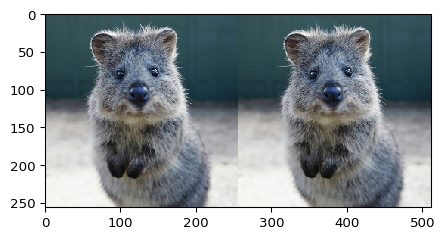

After:


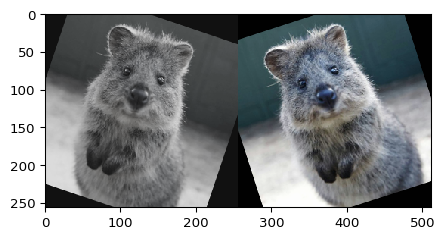

In [1]:
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa
%matplotlib inline

ia.seed(3)

class AugSequence:
    def __init__(self):
        # instantiate each augmenter and save it to its own variable
        self.affine = iaa.Affine(rotate=(-20, 20), translate_px={"x": (-10, 10), "y": (-5, 5)})
        self.multiply = iaa.Multiply((0.9, 1.1))
        self.contrast = iaa.LinearContrast((0.8, 1.2))
        self.gray = iaa.Grayscale((0.0, 1.0))
    
    def augment_images(self, x):
        # apply each augmenter on its own, one by one
        x = self.affine.augment_images(x)
        x = self.multiply.augment_images(x)
        x = self.contrast.augment_images(x)
        x = self.gray.augment_images(x)
        return x

aug = AugSequence()

image = ia.quokka_square(size=(256, 256))  # uint8 array of shape (256, 256, 3)
images_aug = aug.augment_images([image, image])

print("Before:")
ia.imshow(np.hstack([image, image]))
print("After:")
ia.imshow(np.hstack(images_aug))

## Single Function

It is also possible to re-instantiate augmenters each time they are used for augmentation. In theory, this incurs a tiny performance penalty (as e.g. parameters have to be parsed each time). The below code block shows an example.

Before:


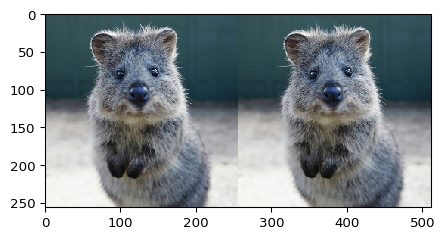

After:


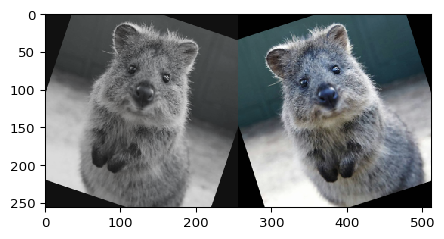

In [2]:
ia.seed(3)
    
def augment_images(x):
    x = iaa.Affine(rotate=(-20, 20)).augment_images(x)
    x = iaa.Multiply((0.9, 1.1)).augment_images(x)
    x = iaa.LinearContrast((0.8, 1.2)).augment_images(x)
    x = iaa.Grayscale((0.0, 1.0)).augment_images(x)
    return x

images_aug = augment_images([image, image])

print("Before:")
ia.imshow(np.hstack([image, image]))
print("After:")
ia.imshow(np.hstack(images_aug))

## Some Time Measurements

How long does it take to instantiate an augmenter? We can measure that, here with `Affine` and a large number of parameters as an example:

In [3]:
%timeit -n 10000 iaa.Affine(translate_px=(-10, 10), scale=(0.9, 1.1), rotate=(-20, 20), shear=(-20, 20), mode=ia.ALL)

91.9 µs ± 2.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


As you can see, the required time is tiny, below 0.1ms (measured on rather outdated hardware). An augmentation sequence with 10 augmenters would take less than 1ms to instantiate, which is by far less than the augmentation process.

We can also measure the required time of both methods from further above, the one using a custom class and the single-function method:

In [4]:
%timeit -n 2500 aug.augment_images([image, image])
%timeit -n 2500 augment_images([image, image])

8.83 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 2500 loops each)
9.15 ms ± 671 µs per loop (mean ± std. dev. of 7 runs, 2500 loops each)


As expected, the difference per call is negligible.

## Single Function, Different Input Types

If you want to use the above single-function method to augment images *and* other datatypes, e.g. bounding boxes, you will have to manage random states yourself. This is however not very hard. The following example adds a `seed` argument to align the augmentations between images and bounding boxes:

Before:


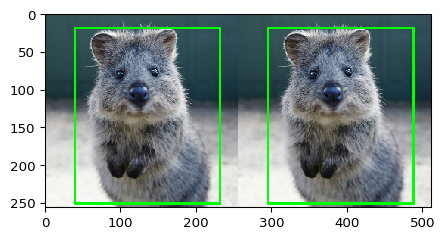

After:


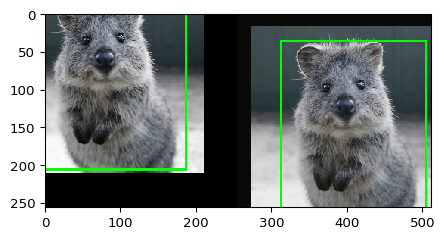

In [7]:
def augment_images(x, seed):
    x = iaa.Affine(translate_px=(-60, 60), random_state=seed).augment_images(x)
    x = iaa.Multiply((0.9, 1.1), random_state=seed).augment_images(x)
    x = iaa.LinearContrast((0.8, 1.2), random_state=seed).augment_images(x)
    x = iaa.Grayscale((0.0, 1.0), random_state=seed).augment_images(x)
    return x

# new function
def augment_bounding_boxes(x, seed):
    x = iaa.Affine(translate_px=(-60, 60), random_state=seed).augment_bounding_boxes(x)
    x = iaa.Multiply((0.9, 1.1), random_state=seed).augment_bounding_boxes(x)
    x = iaa.LinearContrast((0.8, 1.2), random_state=seed).augment_bounding_boxes(x)
    x = iaa.Grayscale((0.0, 1.0), random_state=seed).augment_bounding_boxes(x)
    return x

# bounding boxes to augment
bbsoi = ia.BoundingBoxesOnImage(
    bounding_boxes=[ia.BoundingBox(x1=40, y1=20, x2=230, y2=250)],
    shape=image.shape)

# augment images and bounding boxes
images_aug = augment_images([image, image], seed=2)
bbsois_aug = augment_bounding_boxes([bbsoi, bbsoi], seed=2)

print("Before:")
ia.imshow(
    np.hstack([
        bbsoi.draw_on_image(image, thickness=3),
        bbsoi.draw_on_image(image, thickness=3),
    ])
)

print("After:")
ia.imshow(
    np.hstack([
        bbsois_aug[0].draw_on_image(images_aug[0], thickness=3),
        bbsois_aug[1].draw_on_image(images_aug[1], thickness=3)
    ])
)